# Use these scripts to transform the Whales Dataset

In [25]:
import os
import math
import glob

import matplotlib.pyplot as plt
import seaborn as sns
import json
import numpy as np
import pandas as pd
from skimage import io
from skimage.transform import AffineTransform, warp, resize

%matplotlib inline

In [26]:
TRAIN_IMAGE_DIR = './data/train/'
TEST_IMAGE_DIR = './data/test/'
TRAIN_PREDICTIONS_JSON_PATH = './data/train/predictions-hf-rot.json'
TEST_PREDICTIONS_JSON_PATH = './data/test/predictions-hf-rot.json'

In [39]:
def crop(im_path, annos):
    image = io.imread(im_path)
    w, h = image.shape[:2]
    
    pad = 50
    
    pts = np.array([[o['x'] * h, o['y'] * w] for o in annos], np.float32)
    top_x, top_y = max(0, int(np.min(pts[:,1])) - pad), max(0, int(np.min(pts[:,0])) - pad)
    bot_x, bot_y = min(w, int(np.max(pts[:,1])) + pad), min(h, int(np.max(pts[:,0])) + pad)

    return resize(image[top_x:bot_x, top_y:bot_y], (224, 224))

In [28]:
def deskew(im_path, annos, template):
    image = io.imread(im_path)
    w, h = image.shape[:2]
    
    pts = np.array([[o['x'] * h, o['y'] * w] for o in annos], np.float32)
    template[:, 0] *= w
    template[:, 1] *= h
    
    tform = AffineTransform()
    tform.estimate(template, pts)
    return resize(warp(image, tform, output_shape=(h//2, w), mode='edge'), (224, 224))

In [29]:
def deskew_all(dataset):
    if dataset == 'train':
        json_path = TRAIN_PREDICTIONS_JSON_PATH
        new_img_dir = os.path.join(TRAIN_IMAGE_DIR, 'deskewed')
        img_dir = TRAIN_IMAGE_DIR
    elif dataset == 'test':
        json_path = TEST_PREDICTIONS_JSON_PATH
        new_img_dir = os.path.join(TEST_IMAGE_DIR, 'deskewed')
        img_dir = TEST_IMAGE_DIR
    else:
        raise ValueError(f'Dataset argument expected either "train" or "test" and got "{dataset}".')

    TEMPLATE = np.array([[0.05, 0.05], [0.5, 0.3], [0.95, 0.05], [0.5, 0.5]], np.float32)
    
    if not os.path.exists(new_img_dir):
        os.makedirs(new_img_dir)
    
    with open(json_path) as f:
        json_data = f.read()
        predictions = json.loads(json_data)
    
    images = glob.glob(img_dir + '*.jpg')
    images = [os.path.basename(x) for x in images]
    
    fig = plt.figure(figsize=(16, 8))
    for i, im_name in enumerate(predictions):
        if len(predictions[im_name]) != 4:
            continue
        im_path = os.path.join(img_dir, im_name)
        new_im = deskew(im_path, predictions[im_name], TEMPLATE.copy())
        io.imsave(os.path.join(new_img_dir, im_name), new_im)
        
        if i < 10:
            ax = plt.subplot(2, 5, i+1)
            plt.imshow(new_im, cmap='gray')
        elif i == 10:
            plt.show()
    
    print(f'Deskewed {len(predictions)} whale flukes!')    

In [41]:
def crop_all(dataset):
    if dataset == 'train':
        json_path = TRAIN_PREDICTIONS_JSON_PATH
        new_img_dir = os.path.join(TRAIN_IMAGE_DIR, 'cropped')
        img_dir = TRAIN_IMAGE_DIR
    elif dataset == 'test':
        json_path = TEST_PREDICTIONS_JSON_PATH
        new_img_dir = os.path.join(TEST_IMAGE_DIR, 'cropped')
        img_dir = TEST_IMAGE_DIR
    else:
        raise ValueError(f'Dataset argument expected either "train" or "test" and got "{dataset}".')
    
    if not os.path.exists(new_img_dir):
        os.makedirs(new_img_dir)
    
    with open(json_path) as f:
        json_data = f.read()
        predictions = json.loads(json_data)
    
    images = glob.glob(img_dir + '*.jpg')
    images = [os.path.basename(x) for x in images]
    
    fig = plt.figure(figsize=(16, 8))
    for i, im_name in enumerate(predictions):
        if len(predictions[im_name]) != 4:
            continue
        im_path = os.path.join(img_dir, im_name)
        new_im = crop(im_path, predictions[im_name])
        io.imsave(os.path.join(new_img_dir, im_name), new_im)
        
        if i < 10:
            ax = plt.subplot(2, 5, i+1)
            plt.imshow(new_im, cmap='gray')
        elif i == 10:
            plt.show()

    print(f'Cropped {len(predictions)} whale flukes!')        

/home/paperspace/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/paperspace/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


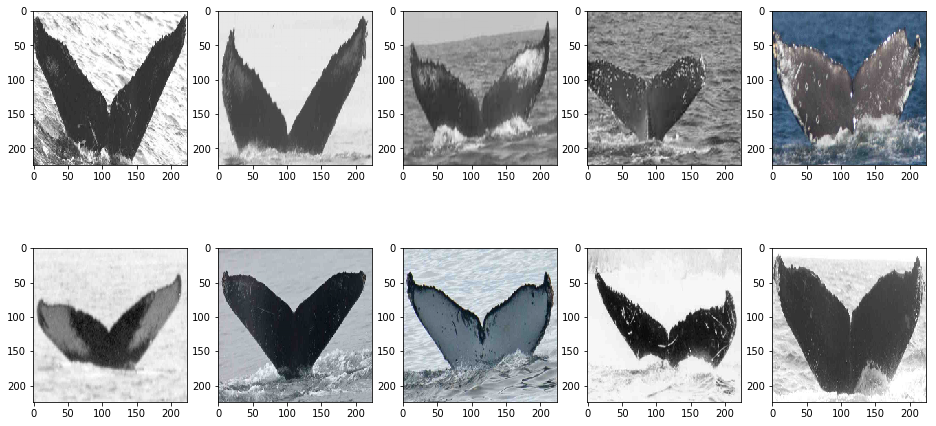

Cropped 9850 whale flukes!


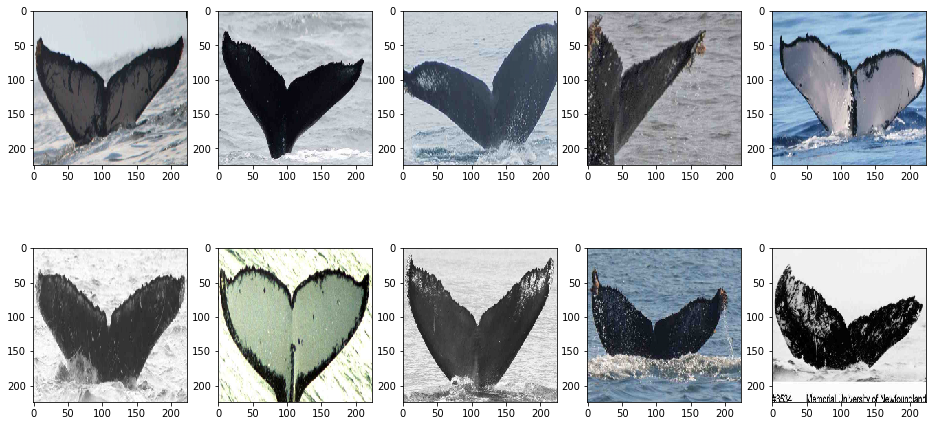

Cropped 15610 whale flukes!


In [42]:
crop_all('train')
crop_all('test')

/home/paperspace/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/paperspace/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


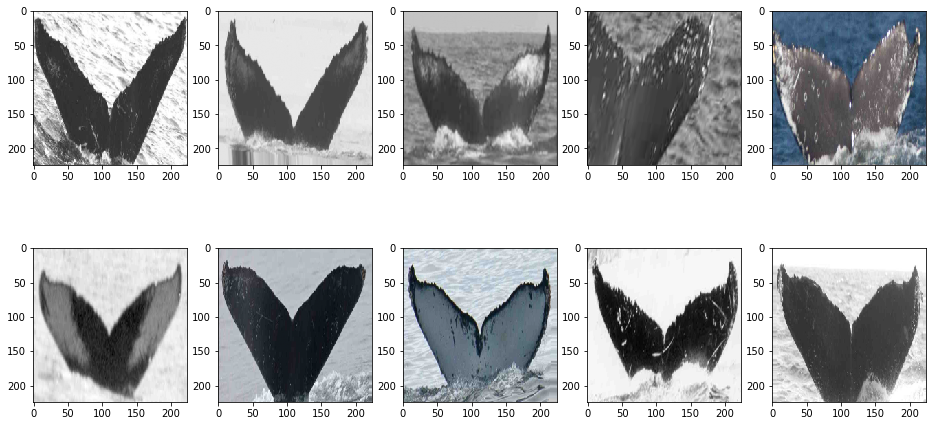

Deskewed 9850 whale flukes!


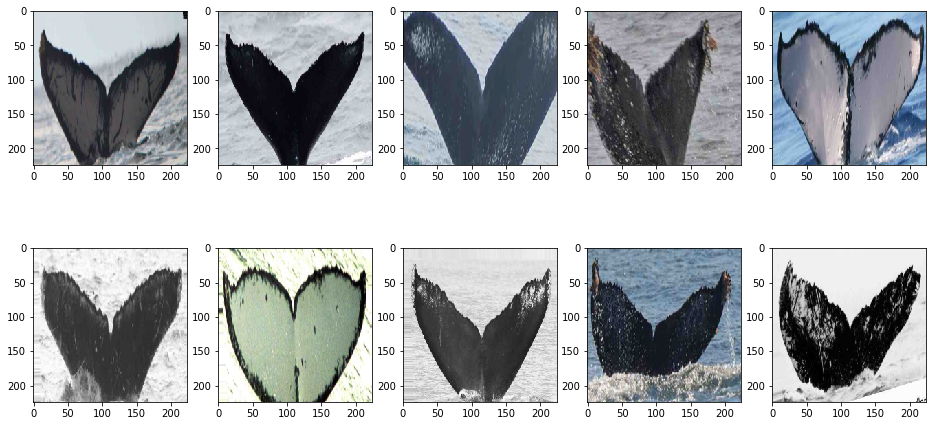

/home/paperspace/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: ./data/test/deskewed/685ee6c0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/paperspace/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: ./data/test/deskewed/bd5e394c.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/paperspace/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: ./data/test/deskewed/cf66720a.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)


Deskewed 15610 whale flukes!


In [43]:
deskew_all('train')
deskew_all('test')